# Evaluate the Effect of Error Threshold
A decision in training is how much we should trade off between structures which are similar to the training set and those which might be unrealistic. 
We control this tradeoff by changing how large of an error we target when producing new structures.


In [1]:
%matplotlib inline
from matplotlib import pyplot as plt
from pathlib import Path
import pandas as pd
import json

## Get the runs
We want the runs named `ttm_md-1000_thr-*`

In [2]:
runs = list(Path('../prod-runs/').glob('ttm_md-1000_thr-*'))
print(f'Found {len(runs)} runs')

Found 4 runs


Make sure training parameters for the network were the same

In [3]:
params = json.loads((runs[0] / 'final-model' / 'params.json').read_text())
params.pop('run_dir')
for run in runs:
    my_params = json.loads((run / 'final-model' / 'params.json').read_text())
    my_params.pop('run_dir')
    assert my_params == params, f'{run} is different'

## Measure the Errors on a Hold-out Set
Get the errors for each network in force and energy

In [4]:
data = []
for run in runs:
    # Get the energy tolerance of my run
    params = json.loads((run / 'runparams.json').read_text())
    energy_tol = params['energy_tolerance']
    
    try:
        # Get the mean error in energy and force for all trajectories
        eval_data = pd.read_csv(run / 'processed-results' / 'benchmark.csv')
        eval_data['energy_error_per_atom'] = eval_data['energy_error_per_atom'].abs() * 1000
        eval_data['energy_error_per_atom-init'] = eval_data['energy_error_per_atom-init'].abs() * 1000
        all_errors = eval_data.groupby('traj')[['energy_error_per_atom', 'force_rmsd', 'energy_error_per_atom-init', 'force_rmsd-init']].mean()
        
        # Store the mean and SEM for each
        record = {'energy_tol': energy_tol}
        for c in all_errors.columns:
            record[f'{c}-mean'] = all_errors[c].mean()
            record[f'{c}-sem'] = all_errors[c].sem()
        data.append(record)
        
    except FileNotFoundError:
        continue
data = pd.DataFrame(data).sort_values('energy_tol')

We now have the errors and for each error tolerance

In [5]:
data

,energy_tol,energy_error_per_atom-mean,energy_error_per_atom-sem,force_rmsd-mean,force_rmsd-sem,energy_error_per_atom-init-mean,energy_error_per_atom-init-sem,force_rmsd-init-mean,force_rmsd-init-sem
2,0.0025,0.480486,0.025678,0.153233,0.003570,0.611804,0.025899,0.295861,0.00772
1,0.0050,0.847481,0.034911,0.252033,0.011402,0.611804,0.025899,0.295861,0.00772
3,0.0100,0.595829,0.049985,0.233876,0.008889,0.611804,0.025899,0.295861,0.00772
0,0.0200,2.058102,0.133091,0.495910,0.023578,0.611804,0.025899,0.295861,0.00772


Make a figure

Text(0.5, 0, 'Target Error (meV/atom)')

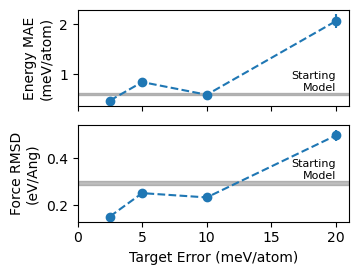

In [6]:
fig, axs = plt.subplots(2, 1, sharex=True, figsize=(3.5, 2.75))

axs[0].set_xlim([0, 21])
for ax, t in zip(axs, ['energy_error_per_atom', 'force_rmsd']):
    # Plot the initial model
    ax.errorbar(data['energy_tol'] * 1000, data[f'{t}-mean'], fmt='--o', yerr=data[f'{t}-sem'])
    
    # Plot the initial model
    row = data.iloc[0]
    ax.fill_between(ax.get_xlim(),
                    y1=row[f'{t}-init-mean'] + row[f'{t}-init-sem'],
                    y2=row[f'{t}-init-mean'] - row[f'{t}-init-sem'],
                   color='gray', alpha=0.5)
    ax.text(20, row[f'{t}-init-mean'] + row[f'{t}-init-sem'], 'Starting\nModel',
           ha='right', va='bottom', fontsize=8)
    
axs[0].set_ylabel('Energy MAE\n(meV/atom)')
axs[1].set_ylabel('Force RMSD\n(eV/Ang)')
axs[-1].set_xlabel('Target Error (meV/atom)')